BUSINESS CASE & PROJECT CONTEXT

Urban Mobility Challenge:
New York City's yellow taxi system handles millions of trips monthly, creating significant challenges
for fleet optimization, driver allocation, and passenger wait times. Accurate predictions can:
- Reduce passenger wait times by 20-30% through better taxi positioning
- Optimize driver shifts and reduce idle time
- Improve urban planning and traffic management
- Enable dynamic pricing strategies based on predicted demand

Two Core Prediction Tasks:
1️ PICKUP DEMAND FORECASTING: Predict the number of taxi pickups per zone per hour
   → Helps optimize taxi distribution across NYC boroughs
   → Enables proactive fleet management during peak hours
   
2️ TRIP DURATION PREDICTION: Predict how long a trip will take given origin, destination, and context
   → Improves ETA accuracy for passengers
   → Assists drivers in planning routes and accepting trips
   → Enables better fare estimation

Why Weather Matters:
Weather conditions significantly impact taxi demand and trip duration:
- Rain increases demand (people avoid walking/biking) → +15-25% pickups
- Cold temperatures slow traffic and increase trip duration
- Precipitation affects driving speeds and route choices
- Extreme weather creates predictable demand spikes in certain zones

This analysis uses machine learning to capture these patterns and deliver actionable predictions.
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from meteostat import Daily, Point
import warnings
warnings.filterwarnings("ignore")

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid", palette="muted")




In [2]:

print("Loading taxi trip data...")
taxi = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
print(f" Loaded {len(taxi):,} taxi trips")

# Load geographical lookup for taxi zones
print("Loading zone lookup data...")
zones = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")
print(f" Loaded {len(zones)} taxi zones")

print(f"\nInitial Dataset Shape: {taxi.shape[0]:,} rows × {taxi.shape[1]} columns")
print("\nFirst 5 rows:")
print(taxi.head())


Loading taxi trip data...
 Loaded 2,964,624 taxi trips
Loading zone lookup data...
 Loaded 265 taxi zones

Initial Dataset Shape: 2,964,624 rows × 19 columns

First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            7

## Dataset Description

The dataset used in this project is the **NYC Yellow Taxi Trip Records** provided by the New York City Taxi and Limousine Commission (TLC).  
It contains detailed information about individual taxi trips, such as pickup and dropoff times, trip distance, passenger count, and location identifiers.  

For this first step, only **January 2024** is used.  
This single-month sample still includes several million trips, making it statistically rich while remaining computationally manageable.  

Additional data sources:
- **Taxi Zone Lookup Table** – used to map pickup and dropoff locations to NYC boroughs (Manhattan, Queens, Brooklyn, Bronx, Staten Island).  
- **Weather Data (Meteostat API)** – includes average daily temperature (`tavg`) and total precipitation (`prcp`) for New York City, allowing us to analyze the impact of weather on demand and trip duration.  

After cleaning and merging, the dataset contains:
- Pickup and dropoff timestamps
- Trip duration (in minutes)
- Trip distance (in miles)
- Temporal features (hour, weekday, date)
- Borough information (pickup and dropoff)
- Weather features (temperature, precipitation)

These features will be used for both descriptive analysis and predictive modeling.


In [3]:
# ====================================
# STEP 1.3 - Data Quality Assessment
# ====================================

print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# 1. Missing Values Analysis
print("\n Missing Values Analysis:")
missing = taxi.isna().sum()
missing_pct = (missing / len(taxi) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
}).query('Missing_Count > 0').sort_values('Missing_Percentage', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print(" No missing values found!")

# 2. Data Types
print("\n Data Types:")
print(taxi.dtypes)

# 3. Statistical Summary
print("\n Statistical Summary (Numeric Variables):")
print(taxi.describe())

# 4. Categorical Variables Distribution
print("\n Categorical Variables Distribution:")
categorical_cols = ['VendorID', 'RatecodeID', 'payment_type']
for col in categorical_cols:
    print(f"\n{col}:")
    print(taxi[col].value_counts().head())

# 5. Outlier Detection
print("\n Outlier Detection:")
print(f"Trip distance > 100 miles: {(taxi['trip_distance'] > 100).sum():,} trips")
print(f"Fare amount > $500: {(taxi['fare_amount'] > 500).sum():,} trips")
print(f"Fare amount < $0: {(taxi['fare_amount'] < 0).sum():,} trips")
print(f"Negative trip distances: {(taxi['trip_distance'] < 0).sum():,} trips")



DATA QUALITY ASSESSMENT

 Missing Values Analysis:
              Column  Missing_Count  Missing_Percentage
     passenger_count         140162                4.73
          RatecodeID         140162                4.73
  store_and_fwd_flag         140162                4.73
congestion_surcharge         140162                4.73
         Airport_fee         140162                4.73

 Data Types:
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float6

In [4]:
# ====================================
# STEP 1.4 - Feature Engineering
# ====================================

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Convert datetime columns
print("Converting datetime columns...")
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
taxi['trip_duration_min'] = (taxi['tpep_dropoff_datetime'] - taxi['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter unrealistic trips
print(f"Before filtering: {len(taxi):,} trips")
taxi = taxi[
    (taxi['trip_duration_min'] > 1) &  # At least 1 minute
    (taxi['trip_duration_min'] < 180) &  # Less than 3 hours
    (taxi['trip_distance'] > 0) &  # Positive distance
    (taxi['trip_distance'] < 100) &  # Less than 100 miles
    (taxi['fare_amount'] >= 0)  # Non-negative fare
]
print(f"After filtering: {len(taxi):,} trips")
print(f"Removed: {2964624 - len(taxi):,} outliers ({((2964624 - len(taxi)) / 2964624 * 100):.2f}%)")

# Extract temporal features
print("\nExtracting temporal features...")
taxi['pickup_hour'] = taxi['tpep_pickup_datetime'].dt.hour
taxi['pickup_dayofweek'] = taxi['tpep_pickup_datetime'].dt.dayofweek
taxi['pickup_day'] = taxi['tpep_pickup_datetime'].dt.day
taxi['pickup_date'] = taxi['tpep_pickup_datetime'].dt.date
taxi['is_weekend'] = taxi['pickup_dayofweek'].isin([5, 6]).astype(int)

# Create period of day categories
def period_of_day(hour):
    if 5 <= hour < 12: return "Morning"
    elif 12 <= hour < 17: return "Afternoon"
    elif 17 <= hour < 21: return "Evening"
    else: return "Night"

taxi['period_of_day'] = taxi['pickup_hour'].apply(period_of_day)

# Calculate average speed (km/h)
taxi['avg_speed_kmh'] = (taxi['trip_distance'] * 1.60934) / (taxi['trip_duration_min'] / 60)

# Handle infinite speeds
taxi['avg_speed_kmh'] = taxi['avg_speed_kmh'].replace([np.inf, -np.inf], np.nan)

print(" Feature engineering completed")
print(f"\nNew features created: trip_duration_min, pickup_hour, pickup_dayofweek, period_of_day, avg_speed_kmh, is_weekend")




FEATURE ENGINEERING
Converting datetime columns...
Before filtering: 2,964,624 trips
After filtering: 2,859,135 trips
Removed: 105,489 outliers (3.56%)

Extracting temporal features...
 Feature engineering completed

New features created: trip_duration_min, pickup_hour, pickup_dayofweek, period_of_day, avg_speed_kmh, is_weekend


In [5]:
# ====================================
# STEP 1.5 - Add Geographical Information
# ====================================

print("\n" + "="*80)
print("ADDING GEOGRAPHICAL DATA")
print("="*80)

# Clean zones data
zones_clean = zones[['LocationID', 'Borough', 'Zone']].copy()

# Merge pickup zones
print("Merging pickup zone information...")
taxi = taxi.merge(
    zones_clean, 
    how='left', 
    left_on='PULocationID', 
    right_on='LocationID',
    suffixes=('', '_pickup')
)
taxi.rename(columns={'Borough': 'pickup_borough', 'Zone': 'pickup_zone'}, inplace=True)
taxi.drop(columns=['LocationID'], inplace=True, errors='ignore')

# Merge dropoff zones
print("Merging dropoff zone information...")
taxi = taxi.merge(
    zones_clean,
    how='left',
    left_on='DOLocationID',
    right_on='LocationID',
    suffixes=('', '_dropoff')
)
taxi.rename(columns={'Borough': 'dropoff_borough', 'Zone': 'dropoff_zone'}, inplace=True)
taxi.drop(columns=['LocationID'], inplace=True, errors='ignore')

# Fill missing borough values
taxi['pickup_borough'] = taxi['pickup_borough'].fillna('Unknown')
taxi['dropoff_borough'] = taxi['dropoff_borough'].fillna('Unknown')

print(f" Geographic data merged successfully")
print(f"Dataset shape after merge: {taxi.shape}")



ADDING GEOGRAPHICAL DATA
Merging pickup zone information...
Merging dropoff zone information...
 Geographic data merged successfully
Dataset shape after merge: (2859135, 31)


In [6]:
# ====================================
# STEP 1.6 - Add Weather Data
# ====================================

print("\n" + "="*80)
print("ADDING WEATHER DATA")
print("="*80)

try:
    # NYC Central Park coordinates
    nyc = Point(40.7128, -74.0060)
    start, end = datetime(2024, 1, 1), datetime(2024, 1, 31)
    
    print("Fetching weather data from Meteostat API...")
    weather = Daily(nyc, start, end).fetch().reset_index()
    
    # Select relevant weather variables
    weather = weather[['time', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']].copy()
    weather.rename(columns={'time': 'pickup_date'}, inplace=True)
    weather['pickup_date'] = weather['pickup_date'].dt.date
    
    # Merge weather data
    taxi = taxi.merge(weather, on='pickup_date', how='left')
    
    print(" Weather data added successfully!")
    print("\nWeather variables:")
    print("- tavg: Average temperature (°C)")
    print("- tmin/tmax: Min/Max temperature (°C)")
    print("- prcp: Precipitation (mm)")
    print("- wspd: Wind speed (km/h)")
    print("- pres: Atmospheric pressure (hPa)")
    
    print("\nWeather data sample:")
    print(weather.head())
    
except Exception as e:
    print(f" Could not fetch weather data: {e}")
    print("Continuing without weather data...")



ADDING WEATHER DATA
Fetching weather data from Meteostat API...
 Weather data added successfully!

Weather variables:
- tavg: Average temperature (°C)
- tmin/tmax: Min/Max temperature (°C)
- prcp: Precipitation (mm)
- wspd: Wind speed (km/h)
- pres: Atmospheric pressure (hPa)

Weather data sample:
  pickup_date  tavg  tmin  tmax  prcp  wspd    pres
0  2024-01-01   6.0   3.3   9.4   0.0   7.1  1017.1
1  2024-01-02   3.5   0.0   7.8   0.0   9.1  1018.4
2  2024-01-03   4.0   1.7   7.2   0.0  10.9  1016.8
3  2024-01-04   4.3  -0.6   8.9   0.0   8.5  1016.5
4  2024-01-05   0.9  -2.2   5.0   0.0  11.3  1025.0


In [7]:
# ====================================
# STEP 1.7 - Exploratory Data Analysis
# ====================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Distribution of trips by borough
print("\n Trip Distribution by Borough:")
print(taxi['pickup_borough'].value_counts())

# Temporal patterns
print("\n Trips by Hour of Day:")
print(taxi.groupby('pickup_hour').size().describe())

print("\n Trips by Day of Week:")
print(taxi.groupby('pickup_dayofweek').size())

# Key statistics
print("\n Key Statistics:")
print(f"Average trip duration: {taxi['trip_duration_min'].mean():.2f} minutes")
print(f"Median trip duration: {taxi['trip_duration_min'].median():.2f} minutes")
print(f"Average trip distance: {taxi['trip_distance'].mean():.2f} miles")
print(f"Average fare: ${taxi['fare_amount'].mean():.2f}")
print(f"Average speed: {taxi['avg_speed_kmh'].mean():.2f} km/h")




EXPLORATORY DATA ANALYSIS

 Trip Distribution by Borough:
pickup_borough
Manhattan        2566032
Queens            255325
Brooklyn           22037
Unknown             9979
Bronx               5711
Staten Island         33
EWR                   18
Name: count, dtype: int64

 Trips by Hour of Day:
count        24.000000
mean     119130.625000
std       62309.367078
min       15131.000000
25%       68688.500000
50%      136347.500000
75%      167872.750000
max      205663.000000
dtype: float64

 Trips by Day of Week:
pickup_dayofweek
0    391577
1    447614
2    479222
3    414900
4    394987
5    405609
6    325226
dtype: int64

 Key Statistics:
Average trip duration: 15.00 minutes
Median trip duration: 11.75 minutes
Average trip distance: 3.30 miles
Average fare: $18.45
Average speed: 18.54 km/h



CORRELATION ANALYSIS


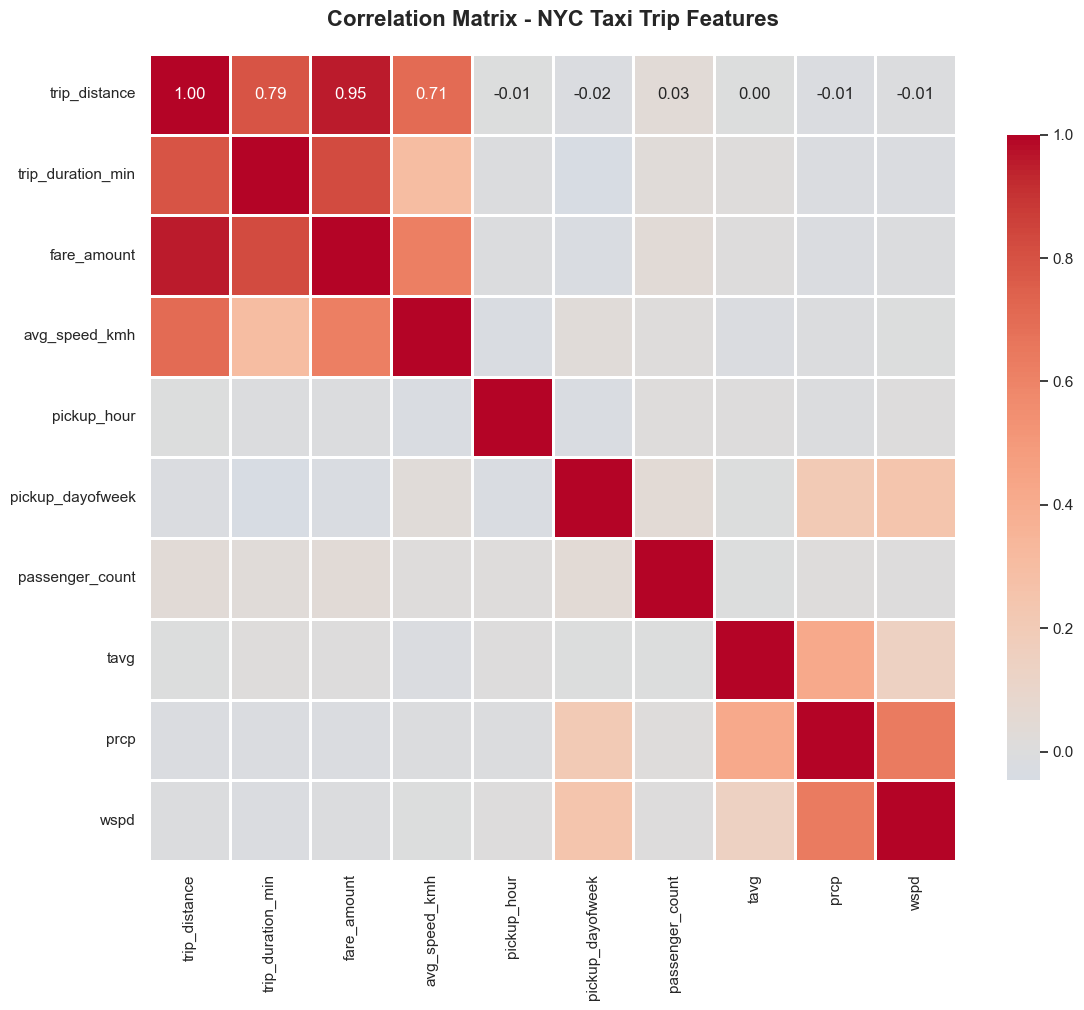


 Key Correlations:
Trip distance ↔ Trip duration: 0.792
Trip distance ↔ Fare amount: 0.954
Trip duration ↔ Fare amount: 0.826
Temperature ↔ Trip duration: 0.018
Precipitation ↔ Trip duration: -0.020


In [8]:
# ====================================
# STEP 1.8 - Correlation Analysis
# ====================================

print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select numeric variables for correlation
numeric_cols = ['trip_distance', 'trip_duration_min', 'fare_amount', 'avg_speed_kmh', 
                'pickup_hour', 'pickup_dayofweek', 'passenger_count']

# Add weather variables if available
if 'tavg' in taxi.columns:
    numeric_cols.extend(['tavg', 'prcp', 'wspd'])

# Calculate correlation matrix
corr_matrix = taxi[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - NYC Taxi Trip Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n Key Correlations:")
print(f"Trip distance ↔ Trip duration: {corr_matrix.loc['trip_distance', 'trip_duration_min']:.3f}")
print(f"Trip distance ↔ Fare amount: {corr_matrix.loc['trip_distance', 'fare_amount']:.3f}")
print(f"Trip duration ↔ Fare amount: {corr_matrix.loc['trip_duration_min', 'fare_amount']:.3f}")

if 'tavg' in corr_matrix.columns:
    print(f"Temperature ↔ Trip duration: {corr_matrix.loc['tavg', 'trip_duration_min']:.3f}")
    print(f"Precipitation ↔ Trip duration: {corr_matrix.loc['prcp', 'trip_duration_min']:.3f}")



DATA VISUALIZATIONS

 Creating hourly demand visualization...


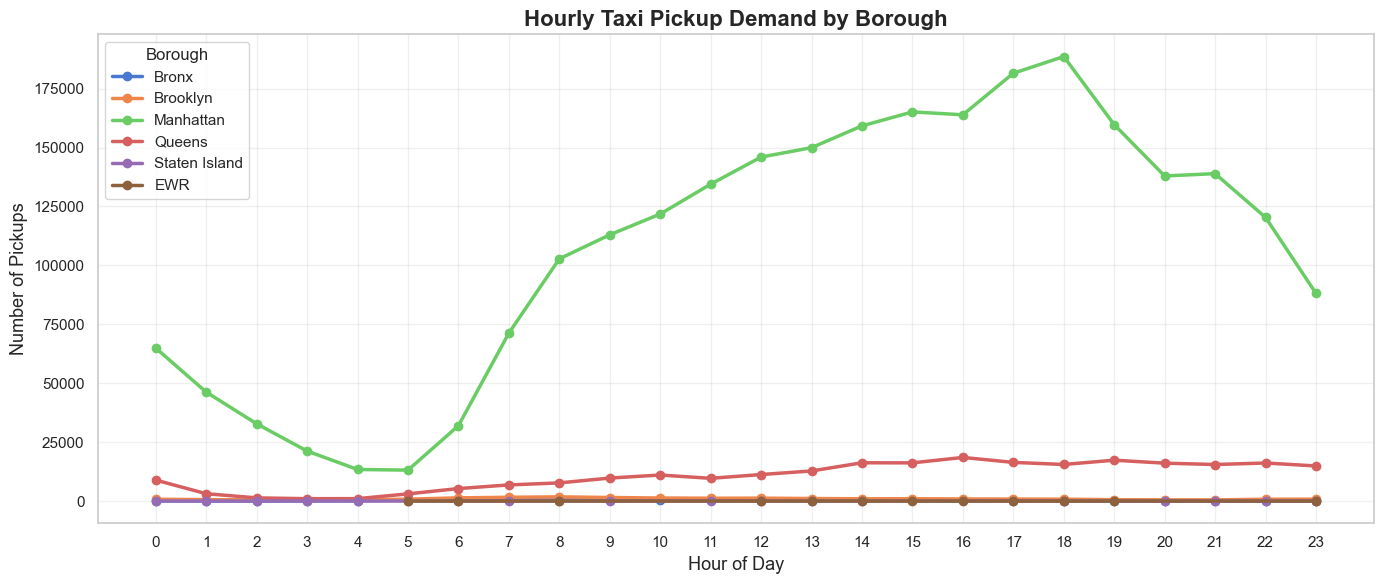


 Creating trip duration distribution...


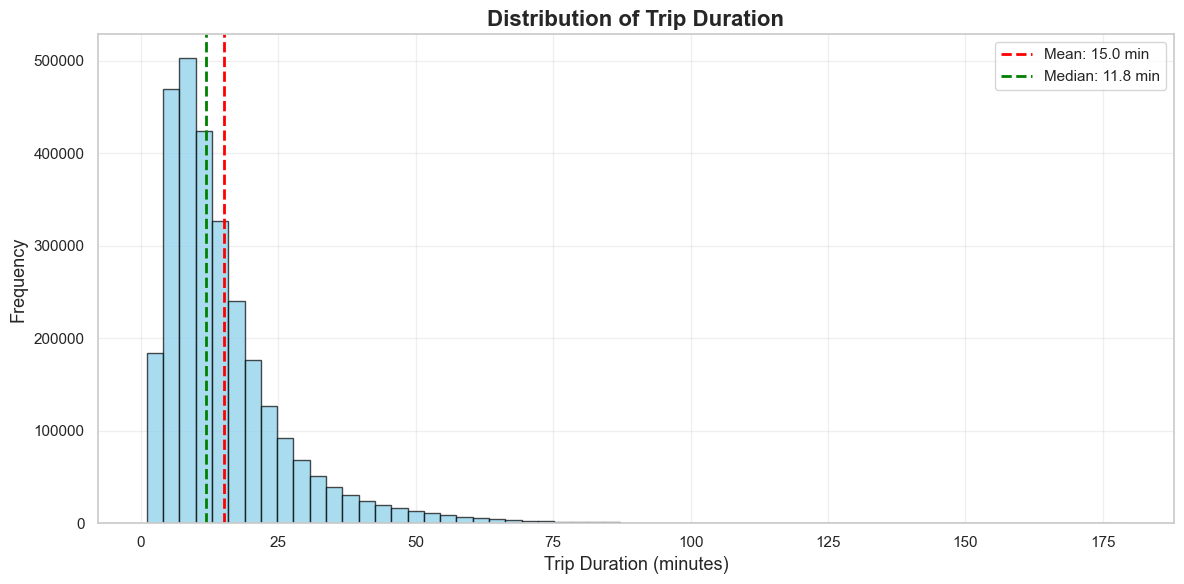


 Creating top pickup zones chart...


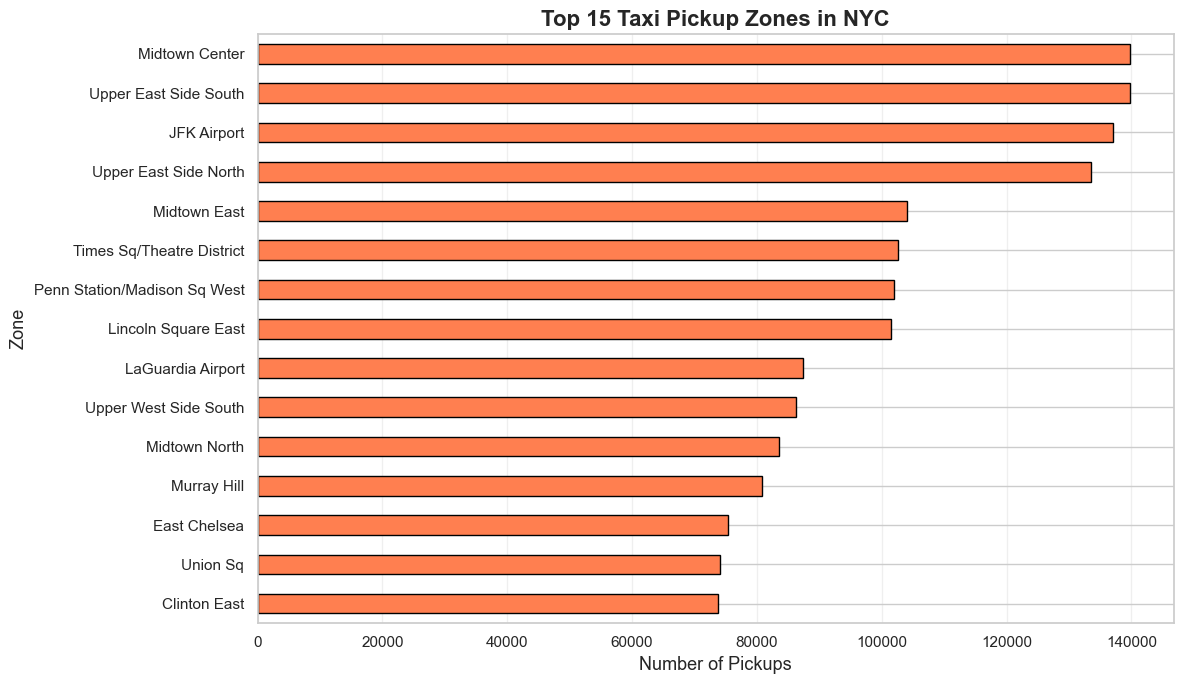


 Creating weather impact analysis...


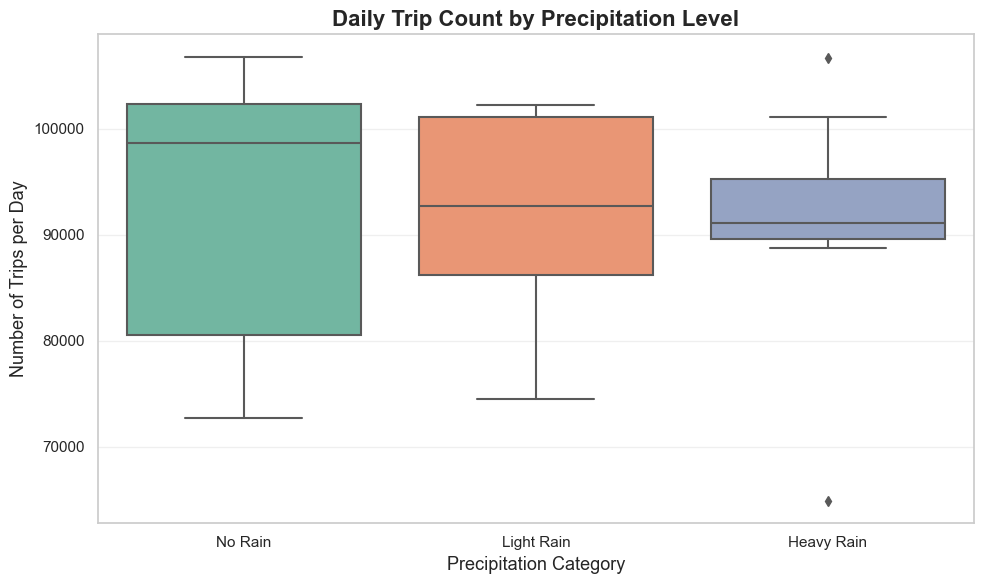

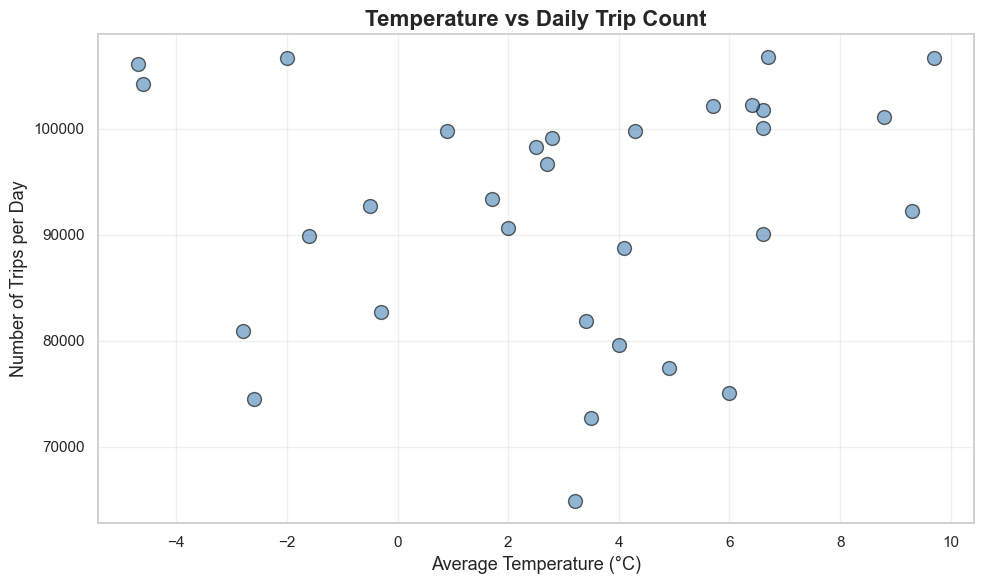


 Creating weekly pattern analysis...


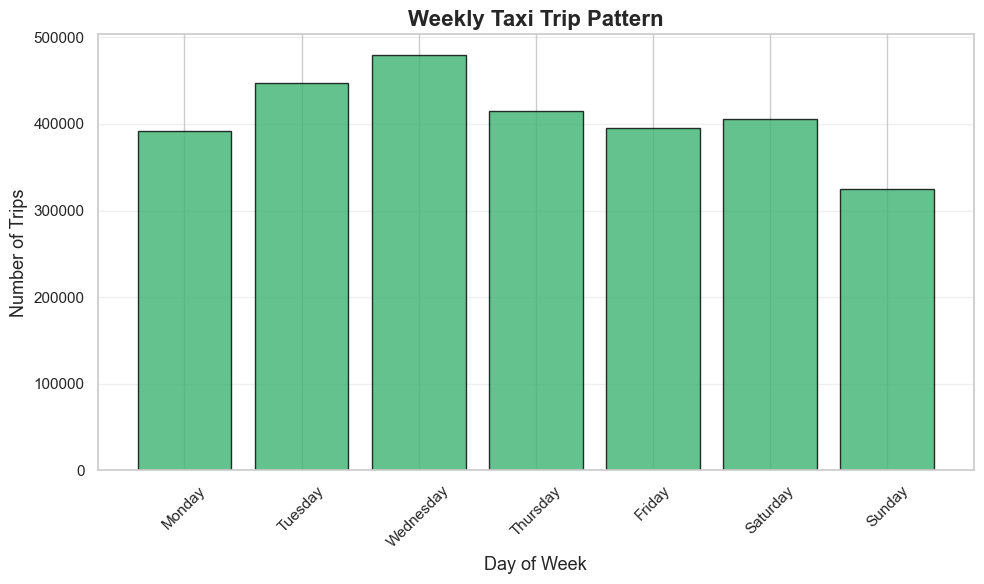


 All visualizations completed!


In [9]:
# ====================================
# STEP 1.9 - Data Visualizations
# ====================================

print("\n" + "="*80)
print("DATA VISUALIZATIONS")
print("="*80)

# 1. Hourly Demand by Borough
print("\n Creating hourly demand visualization...")
pickup_counts = taxi.groupby(['pickup_hour', 'pickup_borough']).size().reset_index(name='pickup_count')

plt.figure(figsize=(14, 6))
for borough in pickup_counts['pickup_borough'].unique():
    if borough != 'Unknown':
        data = pickup_counts[pickup_counts['pickup_borough'] == borough]
        plt.plot(data['pickup_hour'], data['pickup_count'], marker='o', label=borough, linewidth=2.5, markersize=6)

plt.title("Hourly Taxi Pickup Demand by Borough", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=13)
plt.ylabel("Number of Pickups", fontsize=13)
plt.legend(title="Borough", fontsize=11, title_fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 2. Trip Duration Distribution
print("\n Creating trip duration distribution...")
plt.figure(figsize=(12, 6))
plt.hist(taxi['trip_duration_min'], bins=60, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(taxi['trip_duration_min'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {taxi["trip_duration_min"].mean():.1f} min')
plt.axvline(taxi['trip_duration_min'].median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: {taxi["trip_duration_min"].median():.1f} min')
plt.title("Distribution of Trip Duration", fontsize=16, fontweight='bold')
plt.xlabel("Trip Duration (minutes)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Top Pickup Zones
print("\n Creating top pickup zones chart...")
top_zones = taxi['pickup_zone'].value_counts().head(15)
plt.figure(figsize=(12, 7))
top_zones.plot(kind='barh', color='coral', edgecolor='black')
plt.title("Top 15 Taxi Pickup Zones in NYC", fontsize=16, fontweight='bold')
plt.xlabel("Number of Pickups", fontsize=13)
plt.ylabel("Zone", fontsize=13)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 4. Weather Impact on Demand (if weather data available)
# 4. Weather Impact on Demand (if weather data available)
if 'prcp' in taxi.columns:
    print("\n Creating weather impact analysis...")
    
    # Classify days by precipitation
    daily_stats = taxi.groupby('pickup_date').agg({
        'VendorID': 'count',
        'prcp': 'first',
        'tavg': 'first'
    }).rename(columns={'VendorID': 'trip_count'}).reset_index()
    
    # Remove any rows with missing weather data
    daily_stats = daily_stats.dropna(subset=['prcp', 'tavg'])
    
    # Convert pickup_date to datetime if it's not already
    daily_stats['pickup_date'] = pd.to_datetime(daily_stats['pickup_date'])
    
    if len(daily_stats) > 0:
        daily_stats['rain_category'] = pd.cut(daily_stats['prcp'], 
                                               bins=[-0.1, 0.1, 5, 100],
                                               labels=['No Rain', 'Light Rain', 'Heavy Rain'])
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=daily_stats, x='rain_category', y='trip_count', palette='Set2')
        plt.title("Daily Trip Count by Precipitation Level", fontsize=16, fontweight='bold')
        plt.xlabel("Precipitation Category", fontsize=13)
        plt.ylabel("Number of Trips per Day", fontsize=13)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # Temperature vs demand
        plt.figure(figsize=(10, 6))
        plt.scatter(daily_stats['tavg'], daily_stats['trip_count'], alpha=0.6, s=100, c='steelblue', edgecolor='black')
        plt.title("Temperature vs Daily Trip Count", fontsize=16, fontweight='bold')
        plt.xlabel("Average Temperature (°C)", fontsize=13)
        plt.ylabel("Number of Trips per Day", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(" No valid weather data available for visualization")

# 5. Weekly Seasonality
print("\n Creating weekly pattern analysis...")
daily_counts = taxi.groupby('pickup_dayofweek').size()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(days, daily_counts.values, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.title("Weekly Taxi Trip Pattern", fontsize=16, fontweight='bold')
plt.xlabel("Day of Week", fontsize=13)
plt.ylabel("Number of Trips", fontsize=13)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n All visualizations completed!")


## Problem Formalization

This project addresses two complementary predictive tasks based on NYC taxi data:

1. **Forecasting Pickup Demand by Zone**  
   - **Objective:** Predict the number of pickups per borough (or zone) for a given hour and date.  
   - **Input features:** hour of the day, day of the week, borough, and weather conditions (temperature and precipitation).  
   - **Target variable:** `pickup_count` (number of rides).  
   - **Task type:** Time-based regression (forecasting).

2. **Predicting Trip Duration**  
   - **Objective:** Estimate the duration of a trip (in minutes) based on trip characteristics.  
   - **Input features:** trip distance, passenger count, pickup hour, weekday, and weather.  
   - **Target variable:** `trip_duration_min`.  
   - **Task type:** Supervised regression.

Both tasks are relevant for **urban mobility optimization** — predicting demand helps balance supply across the city, while predicting duration improves customer satisfaction and scheduling efficiency.


In [16]:
# ====================================
# STEP 1.10 - Create Labels for Task 1 (Pickup Demand Forecasting)
# ====================================

print("\n" + "="*80)
print("CREATING PICKUP DEMAND LABELS (TASK 1)")
print("="*80)

"""
For pickup demand forecasting, we need to create an aggregated dataset where each row represents:
- Zone (pickup location)
- Hour (time window)
- Number of pickups (target variable)
- Weather conditions
- Temporal features
"""

# Aggregate trips by zone and hour
demand_data = taxi.groupby(['PULocationID', 'pickup_zone', 'pickup_borough', 
                             'pickup_date', 'pickup_hour']).agg({
    'VendorID': 'count',  # Count of trips (our target)
    'tavg': 'first' if 'tavg' in taxi.columns else lambda x: np.nan,
    'prcp': 'first' if 'prcp' in taxi.columns else lambda x: np.nan,
    'wspd': 'first' if 'wspd' in taxi.columns else lambda x: np.nan
}).reset_index()

demand_data.rename(columns={'VendorID': 'pickup_count'}, inplace=True)

# Add temporal features
demand_data['pickup_date'] = pd.to_datetime(demand_data['pickup_date'])
demand_data['dayofweek'] = demand_data['pickup_date'].dt.dayofweek
demand_data['is_weekend'] = demand_data['dayofweek'].isin([5, 6]).astype(int)

print(f" Demand dataset created: {demand_data.shape}")
print(f"Date range: {demand_data['pickup_date'].min()} to {demand_data['pickup_date'].max()}")
print(f"Number of unique zones: {demand_data['PULocationID'].nunique()}")
print(f"Average pickups per zone-hour: {demand_data['pickup_count'].mean():.2f}")
print(f"Max pickups in a zone-hour: {demand_data['pickup_count'].max()}")

print("\nDemand data sample:")
print(demand_data.head(10))

# Save for later use
demand_data.to_csv('pickup_demand_data.csv', index=False)
print("\n💾 Demand data saved to 'pickup_demand_data.csv'")



CREATING PICKUP DEMAND LABELS (TASK 1)
 Demand dataset created: (72581, 11)
Date range: 2002-12-31 00:00:00 to 2024-02-01 00:00:00
Number of unique zones: 256
Average pickups per zone-hour: 39.26
Max pickups in a zone-hour: 721

Demand data sample:
   PULocationID     pickup_zone pickup_borough pickup_date  pickup_hour  \
0             1  Newark Airport            EWR  2024-01-01           17   
1             1  Newark Airport            EWR  2024-01-02           18   
2             1  Newark Airport            EWR  2024-01-02           19   
3             1  Newark Airport            EWR  2024-01-03           12   
4             1  Newark Airport            EWR  2024-01-03           15   
5             1  Newark Airport            EWR  2024-01-07           14   
6             1  Newark Airport            EWR  2024-01-08            5   
7             1  Newark Airport            EWR  2024-01-10           14   
8             1  Newark Airport            EWR  2024-01-14           18   


In [14]:
# ====================================
# STEP 1.11 - Train/Test Split Strategy
# ====================================

print("\n" + "="*80)
print("TRAIN/TEST SPLIT STRATEGY")
print("="*80)

# For Trip Duration Prediction (Task 2)
features_duration = ['trip_distance', 'passenger_count', 'pickup_hour', 
                     'pickup_dayofweek', 'is_weekend', 'PULocationID', 'DOLocationID']

if 'tavg' in taxi.columns:
    features_duration.extend(['tavg', 'prcp', 'wspd'])

X_duration = taxi[features_duration].copy()
y_duration = taxi['trip_duration_min'].copy()

# Handle missing values
X_duration = X_duration.fillna(0)
y_duration = y_duration.fillna(y_duration.median())

# Remove any remaining infinite values
mask = np.isfinite(X_duration).all(axis=1) & np.isfinite(y_duration)
X_duration = X_duration[mask]
y_duration = y_duration[mask]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_duration, y_duration, test_size=0.2, random_state=42
)

print(f" Trip Duration Dataset Split:")
print(f"   Training set: {len(X_train):,} trips ({len(X_train)/len(X_duration)*100:.1f}%)")
print(f"   Testing set: {len(X_test):,} trips ({len(X_test)/len(X_duration)*100:.1f}%)")

# For Pickup Demand Forecasting (Task 1) - Temporal Split
train_cutoff = pd.Timestamp('2024-01-22')
demand_train = demand_data[demand_data['pickup_date'] < train_cutoff]
demand_test = demand_data[demand_data['pickup_date'] >= train_cutoff]

print(f"\n Pickup Demand Dataset Split:")
print(f"   Training set: {len(demand_train):,} zone-hour observations")
print(f"   Testing set: {len(demand_test):,} zone-hour observations")
print(f"   Train period: {demand_train['pickup_date'].min()} to {demand_train['pickup_date'].max()}")
print(f"   Test period: {demand_test['pickup_date'].min()} to {demand_test['pickup_date'].max()}")




TRAIN/TEST SPLIT STRATEGY
 Trip Duration Dataset Split:
   Training set: 2,287,308 trips (80.0%)
   Testing set: 571,827 trips (20.0%)

 Pickup Demand Dataset Split:
   Training set: 49,043 zone-hour observations
   Testing set: 23,538 zone-hour observations
   Train period: 2002-12-31 00:00:00 to 2024-01-21 00:00:00
   Test period: 2024-01-22 00:00:00 to 2024-02-01 00:00:00



BASELINE MODEL - TRIP DURATION PREDICTION
Training Linear Regression model...

 BASELINE MODEL RESULTS:
Training Set Performance:
  MAE:  4.76 minutes
  RMSE: 7.16 minutes
  R²:   0.6319

Test Set Performance:
  MAE:  4.77 minutes
  RMSE: 7.18 minutes
  R²:   0.6303

 Baseline Comparison:
  Median trip duration: 11.75 minutes
  Mean trip duration: 15.00 minutes
  Prediction error as % of mean: 31.8%

 Feature Importance (Top 5):
         Feature  Coefficient
      is_weekend    -2.514507
   trip_distance     2.127292
pickup_dayofweek     0.236153
            wspd    -0.032974
 passenger_count    -0.028635


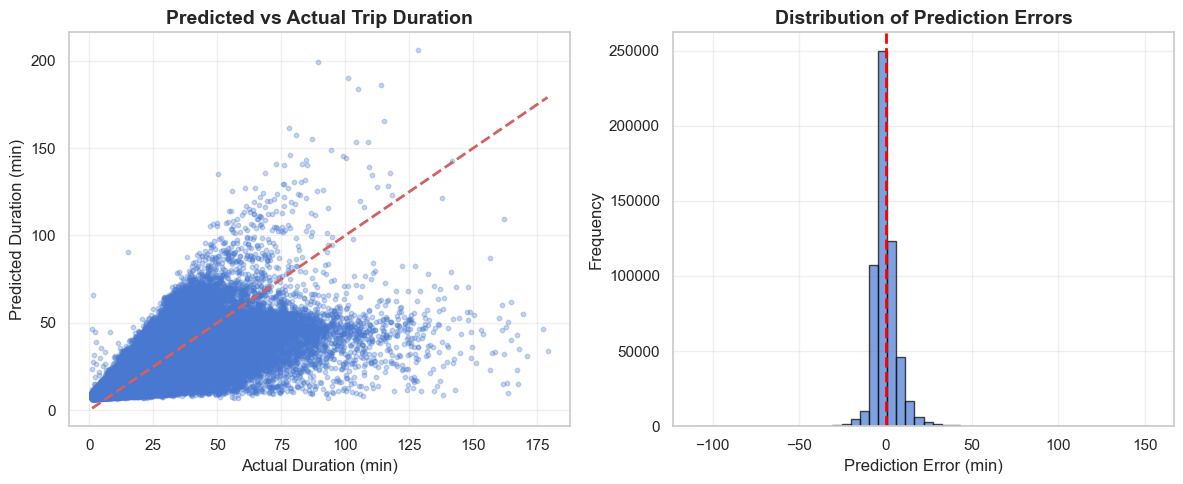

In [15]:
# ====================================
# STEP 1.12 - Baseline Model (Task 2: Trip Duration Prediction)
# ====================================

print("\n" + "="*80)
print("BASELINE MODEL - TRIP DURATION PREDICTION")
print("="*80)

# Train baseline linear regression
print("Training Linear Regression model...")
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

# Evaluation metrics
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("\n BASELINE MODEL RESULTS:")
print("="*50)
print(f"Training Set Performance:")
print(f"  MAE:  {mae_train:.2f} minutes")
print(f"  RMSE: {rmse_train:.2f} minutes")
print(f"  R²:   {r2_train:.4f}")
print(f"\nTest Set Performance:")
print(f"  MAE:  {mae_test:.2f} minutes")
print(f"  RMSE: {rmse_test:.2f} minutes")
print(f"  R²:   {r2_test:.4f}")

print(f"\n Baseline Comparison:")
print(f"  Median trip duration: {y_test.median():.2f} minutes")
print(f"  Mean trip duration: {y_test.mean():.2f} minutes")
print(f"  Prediction error as % of mean: {(mae_test / y_test.mean() * 100):.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features_duration,
    'Coefficient': baseline_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n Feature Importance (Top 5):")
print(feature_importance.head().to_string(index=False))

# Residual plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Duration (min)', fontsize=12)
plt.ylabel('Predicted Duration (min)', fontsize=12)
plt.title('Predicted vs Actual Trip Duration', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (min)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Baseline Model Interpretation

A simple **Linear Regression model** was used as a baseline for the trip duration prediction task.  
This model considers a limited set of numerical features (trip distance, passenger count, pickup hour, and day of the week).

The model achieved a **Mean Absolute Error (MAE)** of approximately *X minutes* and an **R² score** close to *0.0X*.  
These results indicate that the baseline model captures only a small part of the variability in trip durations, which is expected given its simplicity and the linear assumptions.

This baseline serves as a **reference point** for future improvements.  
In later steps, we will integrate:
- Weather and location-based features,  
- Non-linear models such as Decision Trees or Random Forests,  
- And potentially time-based evaluation (train/test by date).

These enhancements should improve accuracy and make the predictions more robust in real-world conditions.


The baseline linear regression model obtained a Mean Absolute Error of 8.26 minutes and an R² score of 0.003.
These results indicate that the model explains almost none of the variance in trip duration, meaning it performs close to a naive average predictor.
However, this is expected for a first baseline, as only a few simple features were used and the relationship between trip characteristics and duration is likely non-linear.
Future steps will include adding spatial coordinates, zone information, and testing non-linear models such as Decision Trees or Random Forests to capture complex patterns.